### Librerías necesarias

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time
import os

### Análisis de resultados

In [3]:
afc_25_completo = pd.read_csv("C:/Users/JORGE/OneDrive/Desktop/TIC/Base/afc_25_completo.csv")

In [4]:
len(afc_25_completo)
#len(afc_25_completo["CodigoTarjeta"].unique())

313276

In [5]:
inferencia_2_val = pd.read_csv("C:/Users/JORGE/OneDrive/Desktop/TIC/Inferencia_destinos/2_val_usuario.csv")
inferencia_3_val = pd.read_csv("C:/Users/JORGE/OneDrive/Desktop/TIC/Inferencia_destinos/3_val_usuario.csv")
inferencia_4_val = pd.read_csv("C:/Users/JORGE/OneDrive/Desktop/TIC/Inferencia_destinos/4_val_usuario.csv")
inferencia_5_val = pd.read_csv("C:/Users/JORGE/OneDrive/Desktop/TIC/Inferencia_destinos/5_val_usuario.csv")
inferencia_6_val = pd.read_csv("C:/Users/JORGE/OneDrive/Desktop/TIC/Inferencia_destinos/6_val_usuario.csv")

In [6]:
afc_25_inferencias = pd.concat([inferencia_2_val, inferencia_3_val, inferencia_4_val, inferencia_5_val, inferencia_6_val], axis=0, ignore_index=True)

In [7]:
len(afc_25_inferencias)

263798

In [8]:
afc_25_1=len(afc_25_completo)-len(afc_25_inferencias)
afc_25_1

49478

In [9]:
afc_25_completo["Tiempo"] = afc_25_completo["Tiempo"].astype(str).str.strip()
afc_25_inferencias["TiempoInicial"] = afc_25_inferencias["TiempoInicial"].astype(str).str.strip()

# Hacemos el merge por tarjeta y hora
resultado = pd.merge(
    afc_25_inferencias,
    afc_25_completo[["CodigoTarjeta", "Tiempo", "TiempoEntreTimbradas_min"]],
    left_on=["CodigoTarjeta", "TiempoInicial"],
    right_on=["CodigoTarjeta", "Tiempo"],
    how="left"
)

# Opcional: eliminar la columna 'Tiempo' duplicada si no la necesitas
afc_25_inferencias = resultado.drop(columns=["Tiempo"])

In [10]:
afc_25_inferencias = afc_25_inferencias.rename(columns={"TiempoInicial": "Tiempo"})

- Colocamos en la base  "Otras" las validaciones únicas en el día.

In [11]:
afc_25_completo["Tiempo_str"] = pd.to_datetime(afc_25_completo["Tiempo"], format="%H:%M:%S").dt.strftime("%H:%M:%S")
afc_25_inferencias["Tiempo_str"] = pd.to_datetime(afc_25_inferencias["Tiempo"], format="%H:%M:%S").dt.strftime("%H:%M:%S")

afc_25_completo["CodigoTarjeta"] = afc_25_completo["CodigoTarjeta"].astype(str)
afc_25_inferencias["CodigoTarjeta"] = afc_25_inferencias["CodigoTarjeta"].astype(str)

afc_25_completo["CodigoParada"] = afc_25_completo["CodigoParada"].astype(str)
afc_25_inferencias["ParadaInicial"] = afc_25_inferencias["ParadaInicial"].astype(str)

In [12]:
# Validaciones en la base completa y en la base con paradas inferidas
validaciones_entrada = set(zip(
    afc_25_completo["CodigoTarjeta"],
    afc_25_completo["Tiempo_str"],
    afc_25_completo["CodigoParada"]
))

validaciones_estimadas = set(zip(
    afc_25_inferencias["CodigoTarjeta"],
    afc_25_inferencias["Tiempo_str"],
    afc_25_inferencias["ParadaInicial"]
))

In [13]:
# Validaciones a las que no se se le infiere el destino
Otras = validaciones_entrada - validaciones_estimadas
Otras = pd.DataFrame(Otras, columns=["CodigoTarjeta", "Tiempo", 'ParadaInicial'])

In [14]:
len(Otras)

49478

- Eliminamos de la base todas las validaciones que el modelo no pudo estimar y las movemos a la base 'Otras'. 

In [15]:
# Filtrar los casos donde no se pudo estimar (incluyendo cierre)
no_estim = afc_25_inferencias[
    afc_25_inferencias["ParadaEstimDescenso"].isin(["No se pudo estimar", "No se pudo estimar (cierre)"])
].copy()

In [16]:
len(no_estim)

38059

In [17]:
len(afc_25_inferencias)-len(no_estim)

225739

In [18]:
(225739/313276)*100

72.05754670003446

Las validaciones que no se pudieron estimar son 38059, esto se debe a que no se encontró paradas candidatas dentro del umbral seleccionado.

In [19]:
no_estim = no_estim[['CodigoTarjeta', 'Tiempo', 'ParadaInicial']]

In [20]:
Otras = pd.concat([no_estim, Otras])

In [21]:
len(Otras)

87537

In [22]:
afc_25_inferencias = afc_25_inferencias[
    ~afc_25_inferencias["ParadaEstimDescenso"].isin(["No se pudo estimar", "No se pudo estimar (cierre)"])
].copy()

In [23]:
len(afc_25_inferencias)

225739

- Movemos de la base con las inferencias 'afc_25_inferencias' a los usuarios cuyas validaciones se realizaron en la misma parada. Hay que mencionar que estos tramos de viajes no se pueden estimar ya que no se observa ningún movimiento espacial y por lo tanto no se puede inferir el punto de descenso. 

In [24]:
# Asegurar que las columnas sean numéricas
afc_25_inferencias["Tg"] = pd.to_numeric(afc_25_inferencias["Tg"], errors="coerce")
afc_25_inferencias["TiempoBus"] = pd.to_numeric(afc_25_inferencias["TiempoBus"], errors="coerce")
afc_25_inferencias["DistanciaCaminata"] = pd.to_numeric(afc_25_inferencias["DistanciaCaminata"], errors="coerce")

# Filtrar filas donde los tres valores son exactamente cero
afc_25_misma_parada = afc_25_inferencias[
    (afc_25_inferencias["Tg"] == 0) &
    (afc_25_inferencias["TiempoBus"] == 0) &
    (afc_25_inferencias["DistanciaCaminata"] == 0)
].copy()

In [25]:
afc_25_misma_parada = afc_25_misma_parada[['CodigoTarjeta', 'Tiempo', 'ParadaInicial']]

In [26]:
len(afc_25_misma_parada)

28825

Son un total de 28825 validaciones que pondremos en una nueva base llamada 'Otras' (junto con los usuarios que realizaron una sola validación al día) para luego inferir la parada de descenso mediante un factor de expansión. 

In [27]:
Otras = pd.concat([afc_25_misma_parada, Otras])

In [28]:
len(Otras)

116362

In [29]:
afc_25_misma_parada["CodigoTarjeta"] = afc_25_misma_parada["CodigoTarjeta"].astype(str)
afc_25_misma_parada["Tiempo"] = afc_25_misma_parada["Tiempo"].astype(str)

afc_25_inferencias["CodigoTarjeta"] = afc_25_inferencias["CodigoTarjeta"].astype(str)
afc_25_inferencias["Tiempo"] = afc_25_inferencias["Tiempo"].astype(str)

# Crear una llave única combinando tarjeta y tiempo
afc_25_misma_parada["llave"] = afc_25_misma_parada["CodigoTarjeta"] + "_" + afc_25_misma_parada["Tiempo"]
afc_25_inferencias["llave"] = afc_25_inferencias["CodigoTarjeta"] + "_" + afc_25_inferencias["Tiempo"]

# Filtrar las filas que NO están en la base de exclusión
afc_25_inferencias = afc_25_inferencias[~afc_25_inferencias["llave"].isin(afc_25_misma_parada["llave"])].copy()

# (opcional) eliminar la columna auxiliar
afc_25_inferencias = afc_25_inferencias.drop(columns="llave")

In [30]:
len(afc_25_inferencias)

196914

Por ahora, la base 'Otras' tiene un total de 116362 validaciones. 

- Ahora, analizamos los casos en los que el tiempo entre timbradas es menor al tiempo generalizado (Tg).  

In [31]:
# Asegurarse de que ambas columnas sean numéricas
afc_25_inferencias["TiempoEntreTimbradas_min"] = pd.to_numeric(afc_25_inferencias["TiempoEntreTimbradas_min"], errors="coerce")
afc_25_inferencias["Tg"] = pd.to_numeric(afc_25_inferencias["Tg"], errors="coerce")

# Eliminar (filtrar fuera) los casos donde TiempoEntreTimbradas_min < Tg
afc_25_tg = afc_25_inferencias[afc_25_inferencias["TiempoEntreTimbradas_min"] < afc_25_inferencias["Tg"]].copy()

In [32]:
len(afc_25_tg)

9029

Notamos que son 9029 validaciones en las que esto ocurre. Ahora, vamos ver la distribución de los tiempos entre timbradas de estas validaciones. 

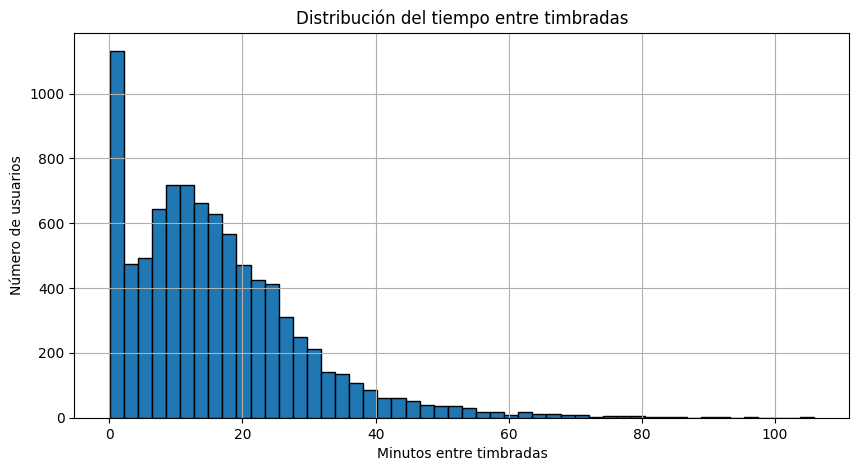

In [33]:
afc_25_tg['TiempoEntreTimbradas_min'].dropna().plot.hist(bins=50, edgecolor='black', figsize=(10, 5))
plt.title('Distribución del tiempo entre timbradas')
plt.xlabel('Minutos entre timbradas')
plt.ylabel('Número de usuarios')
plt.grid(True)
plt.show()

In [34]:
bins = list(range(0, 900 + 1, 5))  # Intervalos de 5 minutos (300 segundos)
afc_25_tg['IntervaloTiempo'] = pd.cut(afc_25_tg['TiempoEntreTimbradas_min'], bins=bins)
frecuencia_por_intervalo = afc_25_tg['IntervaloTiempo'].value_counts().sort_index()
intervalo_mas_comun = frecuencia_por_intervalo.idxmax()
usuarios_en_ese_intervalo = frecuencia_por_intervalo.max()

print(f"🟩 El intervalo con más usuarios es: {intervalo_mas_comun}")
print(f"👥 Número de usuarios en ese intervalo: {usuarios_en_ese_intervalo}")

🟩 El intervalo con más usuarios es: (0, 5]
👥 Número de usuarios en ese intervalo: 1747


Notamos que una gran cantidad de estas validaciones tiene un tiempo entre timbradas menor o igual a 5 minutos. Esta es la razón por la cual asumimos que si las validaciones se dieron dentro de los 5 minutos son un error del sistema y solo nos quedamos con la siguiente validación. Para los otros casos hacemos validos todos los tramos de viajes.

In [35]:
# Marcar las filas que se deben eliminar: si la diferencia con la siguiente es <= 5 minutos
afc_25_tg['Eliminar'] = (afc_25_tg['TiempoEntreTimbradas_min'] <= 5)

In [36]:
# Eliminar solo esas
afc_25_tg_eliminar = afc_25_tg[afc_25_tg['Eliminar']].copy()

In [37]:
len(afc_25_tg_eliminar)

1747

In [38]:
# Eliminar columnas auxiliares 
afc_25_tg.drop(columns=['Eliminar'], inplace=True)

In [39]:
afc_25_tg_eliminar["CodigoTarjeta"] = afc_25_tg_eliminar["CodigoTarjeta"].astype(str)
afc_25_tg_eliminar["Tiempo"] = afc_25_tg_eliminar["Tiempo"].astype(str)

afc_25_inferencias["CodigoTarjeta"] = afc_25_inferencias["CodigoTarjeta"].astype(str)
afc_25_inferencias["Tiempo"] = afc_25_inferencias["Tiempo"].astype(str)

# Crear una llave única combinando tarjeta y tiempo
afc_25_tg_eliminar["llave"] = afc_25_tg_eliminar["CodigoTarjeta"] + "_" + afc_25_tg_eliminar["Tiempo"]
afc_25_inferencias["llave"] = afc_25_inferencias["CodigoTarjeta"] + "_" + afc_25_inferencias["Tiempo"]

# Filtrar las filas que NO están en la base de exclusión
afc_25_inferencias = afc_25_inferencias[~afc_25_inferencias["llave"].isin(afc_25_tg_eliminar["llave"])].copy()

# (opcional) eliminar la columna auxiliar
afc_25_inferencias = afc_25_inferencias.drop(columns="llave")

In [40]:
len(afc_25_inferencias)

195167

In [41]:
len(afc_25_inferencias['ParadaInicial'].unique())

1590

Al final, el número de validaciones que vamos estimar por el factor de expansión son 116362. Y el número de validaciones que tenemos inferidas la parada de descenso son 195167, es decir, el 62.30% de la base luego de la limpieza de los datos. 

In [42]:
round((195167/313276)*100,3)

62.299

### Fact EXP

In [43]:
ruta_carpeta = "C:/Users/JORGE/OneDrive/Desktop/TIC/Base"
os.makedirs(ruta_carpeta, exist_ok=True)

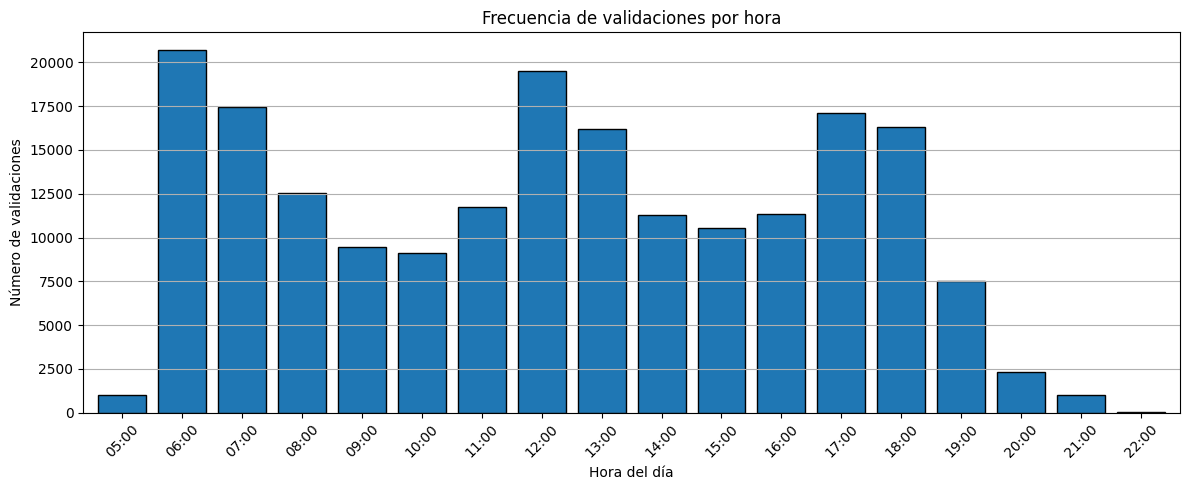

In [44]:
# Asegurar que Tiempo es tipo datetime
afc_25_inferencias["Tiempo"] = pd.to_datetime(afc_25_inferencias["Tiempo"], format="%H:%M:%S", errors="coerce")
Otras["Tiempo"] = pd.to_datetime(Otras["Tiempo"], format="%H:%M:%S", errors="coerce")

# Crear columna con la hora redondeada (franja de 1 hora)
afc_25_inferencias["Hora"] = afc_25_inferencias["Tiempo"].dt.floor("h") 
Otras["Hora"] = Otras["Tiempo"].dt.floor("h") 

# Contar cuántas validaciones hubo por hora
conteo_por_hora = afc_25_inferencias["Hora"].value_counts().sort_index()

plt.figure(figsize=(12, 5))
ax = conteo_por_hora.plot(kind="bar", width=0.8, edgecolor='black')

# Formatear etiquetas del eje X para mostrar solo la hora
ax.set_xticklabels([x.strftime("%H:%M") for x in conteo_por_hora.index])

plt.title("Frecuencia de validaciones por hora")
plt.xlabel("Hora del día")
plt.ylabel("Número de validaciones")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [45]:
def clasificar_banda(hora):
    hora = hora.time()  # Extraer solo la parte de la hora

    if time(5, 0, 0) <= hora <= time(5, 59, 59):
        return "05:00–05:59"
    elif time(6, 0, 0) <= hora <= time(7, 59, 0):
        return "06:00–07:59"
    elif time(8, 0, 0) <= hora <= time(11, 59, 59):
        return "08:00–11:59"
    elif time(12, 0, 0) <= hora <= time(13, 59, 59):
        return "12:00–13:59"
    elif time(14, 0, 0) <= hora <= time(16, 59, 59):
        return "14:00–16:59"
    elif time(17, 0, 0) <= hora <= time(18, 59, 59):
        return "17:00–18:59"
    elif time(19, 0, 0) <= hora <= time(22, 59, 59):
        return "19:00–22:59"
    else:
        return "Fuera de rango"

In [46]:
afc_25_inferencias["banda_tiempo"] = afc_25_inferencias["Hora"].apply(clasificar_banda)

In [47]:
conocidos_por_origen_banda = afc_25_inferencias.groupby(
    ["ParadaInicial", "ParadaEstimDescenso", "banda_tiempo"]
).size().reset_index(name="viajes_inferidos")
conocidos_por_origen_banda["ParadaEstimDescenso"] = conocidos_por_origen_banda["ParadaEstimDescenso"].astype(float)
conocidos_por_origen_banda["ParadaEstimDescenso"] = conocidos_por_origen_banda["ParadaEstimDescenso"].astype("Int64")

In [48]:
Otras["banda_tiempo"] = Otras["Hora"].apply(clasificar_banda)

In [49]:
no_conocidos_por_origen_banda = Otras.groupby(
    ["ParadaInicial", "banda_tiempo"]
).size().reset_index(name="viajes_inferidos")

In [50]:
# Agrupar viajes conocidos por ParadaInicial y banda
conocidos = conocidos_por_origen_banda.groupby(["ParadaInicial", "banda_tiempo"])["viajes_inferidos"].sum().reset_index(name="conocidos")

# Agrupar viajes no conocidos por ParadaInicial y banda
no_conocidos = no_conocidos_por_origen_banda.groupby(["ParadaInicial", "banda_tiempo"])["viajes_inferidos"].sum().reset_index(name="no_conocidos")

# Unir ambas tablas
viajes = pd.merge(conocidos, no_conocidos, on=["ParadaInicial", "banda_tiempo"], how="outer").fillna(0)

# Calcular total de viajes y f_it
viajes["total"] = viajes["conocidos"] + viajes["no_conocidos"]
viajes["f_it"] = viajes["total"] / viajes["conocidos"]

# 5. (Opcional) Reordenar columnas
viajes = viajes[["ParadaInicial", "banda_tiempo", "conocidos", "no_conocidos", "total", "f_it"]]

In [51]:
viajes_expand = viajes[["ParadaInicial", "banda_tiempo", "f_it"]]

viajes_inferidos_expand = pd.merge(
    conocidos_por_origen_banda,
    viajes_expand,
    on=["ParadaInicial", "banda_tiempo"],
    how="left"
)

viajes_inferidos_expand["viajes_expandido"] = viajes_inferidos_expand["viajes_inferidos"] * viajes_inferidos_expand["f_it"]

In [52]:
viajes_inferidos_expand.sort_values("viajes_expandido")

,ParadaInicial,ParadaEstimDescenso,banda_tiempo,viajes_inferidos,f_it,viajes_expandido
83996,93,59,17:00–18:59,1,1.000000,1.000000
48286,2817,2162,08:00–11:59,1,1.000000,1.000000
48283,2817,2064,19:00–22:59,1,1.000000,1.000000
48282,2817,2064,08:00–11:59,1,1.000000,1.000000
85194,986,1881,06:00–07:59,1,1.000000,1.000000
...,...,...,...,...,...,...
30489,2189,3375,08:00–11:59,49,1.768194,86.641509
49367,2848,1866,06:00–07:59,58,1.596491,92.596491
47298,2789,4006,06:00–07:59,67,1.420690,95.186207
30365,2189,2317,08:00–11:59,70,1.768194,123.773585


In [53]:
viajes_inferidos_expand.to_csv(os.path.join(ruta_carpeta, "viajes_inferidos.csv"), index=False)
#viajes_inferidos_expand.to_excel(os.path.join(ruta_carpeta, "viajes_inferidos.xlsx"), index=False)

In [54]:
total_expandido = round(viajes_inferidos_expand['viajes_expandido'].sum())
total_expandido = int(total_expandido)  
total_expandido

310282

In [55]:
# Datos totales - eliminados
313276-1747

311529

In [56]:
# Validaciones que no se pudieron clasificar con factor de expansión
311529-310282

1247

In [57]:
len(Otras)-1247

115115

In [58]:
round((310282/313276)*100,2)

99.04

In [59]:
round((310282/350581)*100,2)

88.51

Notemos que después de usar el factor de expansion tenemos un total de 310282 validaciones con destinos inferidos. Lo que quiere decir que a pesar de usar el fator de expansión aun existen viajes que no podemos estimar. En primer lugar, 1747 validaciones las consideramos como errores al momento de marcar y por eso fueron eliminadas. Ahora, al usar el factor de expansion hay casos en donde en la franja horaria especificada y la parada de origen no se registra ninguna validacion y por lo tanto no se puede aplicar el factor, esto suma un valor de 1247 validaciones. 

En conclusión, estimamos la parada de descenso para el 99.04% de las validaciones de la base despues de la limpieza. Y de la base original sin la limpieza de los datos y con todas la validaciones en el día, hemos inferido el descenso para el 88.51% de las validaciones.

In [60]:
viajes_inferidos_expand.groupby(
    ['ParadaInicial', 'ParadaEstimDescenso'], as_index=False
)['viajes_expandido'].sum().sort_values("viajes_expandido", ascending=False)

,ParadaInicial,ParadaEstimDescenso,viajes_expandido
19969,2789,4006,291.459948
12947,2189,2317,289.239266
31703,4499,2193,277.794783
20772,2848,1866,277.585079
12983,2189,3375,238.677487
...,...,...,...
9842,1901,2032,1.000000
9852,1914,1721,1.000000
9858,1914,4047,1.000000
28961,411,588,1.000000


In [61]:
# Número de usuarios para cada validación
df = afc_25_inferencias.groupby(["CodigoLinea", "ParadaInicial", "ParadaEstimDescenso"]).count()
df = df.rename(columns={'CodigoTarjeta': 'Cantidad_validaciones'})


df = df[['Cantidad_validaciones']]
df.sort_values('Cantidad_validaciones', ascending=False)

Cantidad_validaciones
CodigoLinea ParadaInicial ParadaEstimDescenso                       
1002        2848          1866.0                                 166
7004        2189          2317.0                                 163
6006        4330          2096.0                                 144
            2232          1954.0                                 133
7004        2189          3375.0                                 131
...                                                              ...
9203        4499          3099.0                                   1
                          3069.0                                   1
                          3034.0                                   1
                          2904.0                                   1
                          2752.0                                   1

[41283 rows x 1 columns]

In [62]:
d1 = viajes_inferidos_expand.groupby(["ParadaInicial"]).sum()
d1 = d1[["viajes_expandido"]]
d1.sort_values("viajes_expandido", ascending=False).head(10)

,viajes_expandido
ParadaInicial,
4499,5067.0
2484,4451.0
2317,4102.0
1701,3772.0
4330,3044.0
2255,2778.0
2019,2461.0
4367,2447.0
1772,2141.0


In [63]:
d1 = viajes_inferidos_expand.groupby(["ParadaEstimDescenso"]).sum()
d1 = d1[["viajes_expandido"]]
d1.sort_values("viajes_expandido", ascending=False).head(10).round(0)

,viajes_expandido
ParadaEstimDescenso,
1921,3745.0
2484,3656.0
4499,3223.0
1772,3071.0
2317,3017.0
1701,2654.0
4330,2468.0
1819,2391.0
2193,2372.0
